In [57]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [59]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [60]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [61]:
tf.keras.backend.clear_session()

In [62]:
subject = 'Amazonas - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [63]:
data = pd.read_csv('2003_mo_model_input_AM.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amazonas - Consumo de Cimento (t),Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado
0,2003-1,28.193,0.695898,0.330279,8.630942,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,51.313080,4.754469e+07,2.519796e+06,12.490621,4.318518e+07
1,2003-2,31.226,0.696043,0.331137,8.624872,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,51.554195,4.760190e+07,2.521321e+06,12.492164,4.320154e+07
2,2003-3,33.484,0.696187,0.331306,8.618803,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,51.523306,4.765911e+07,2.522846e+06,12.493707,4.321789e+07
3,2003-4,31.596,0.696332,0.331791,8.612734,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,51.639628,4.771632e+07,2.524370e+06,12.495250,4.323425e+07
4,2003-5,32.919,0.696476,0.332189,8.606665,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,51.838456,4.777353e+07,2.525895e+06,12.496793,4.325060e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,66.077,NaN,0.746275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.352061,NaN,NaN,NaN,NaN
236,2022-9,58.590,NaN,0.746582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.160630,NaN,NaN,NaN,NaN
237,2022-10,58.793,NaN,0.745406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.937187,NaN,NaN,NaN,NaN
238,2022-11,53.509,NaN,0.742703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.889598,NaN,NaN,NaN,NaN


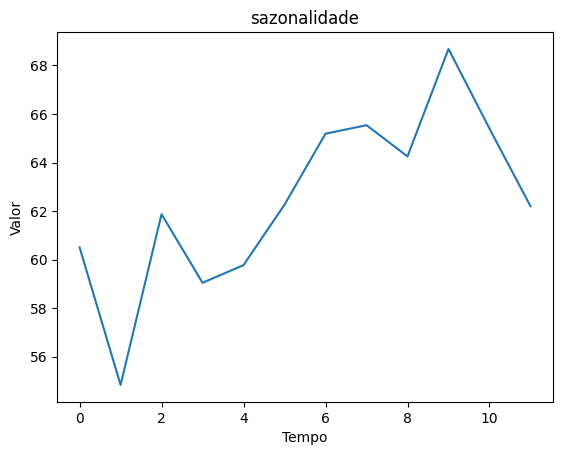

,sazonalidade
sazonalidade,
0,60.508000
1,54.841143
2,61.873571
3,59.048286
4,59.775929
5,62.265429
6,65.187286
7,65.537071
8,64.252429


In [64]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [65]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,51.313080,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,60.508000,28.193
1,2003-2,0.696043,0.331137,8.624872,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,51.554195,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,54.841143,31.226
2,2003-3,0.696187,0.331306,8.618803,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,51.523306,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,61.873571,33.484
3,2003-4,0.696332,0.331791,8.612734,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,51.639628,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,59.048286,31.596
4,2003-5,0.696476,0.332189,8.606665,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,51.838456,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,59.775929,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.746275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.352061,NaN,NaN,NaN,NaN,65.537071,66.077
236,2022-9,NaN,0.746582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.160630,NaN,NaN,NaN,NaN,64.252429,58.590
237,2022-10,NaN,0.745406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.937187,NaN,NaN,NaN,NaN,68.678714,58.793
238,2022-11,NaN,0.742703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.889598,NaN,NaN,NaN,NaN,65.397571,53.509


In [66]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Amazonas - Consumo de Cimento (t), Length: 240, dtype: float64

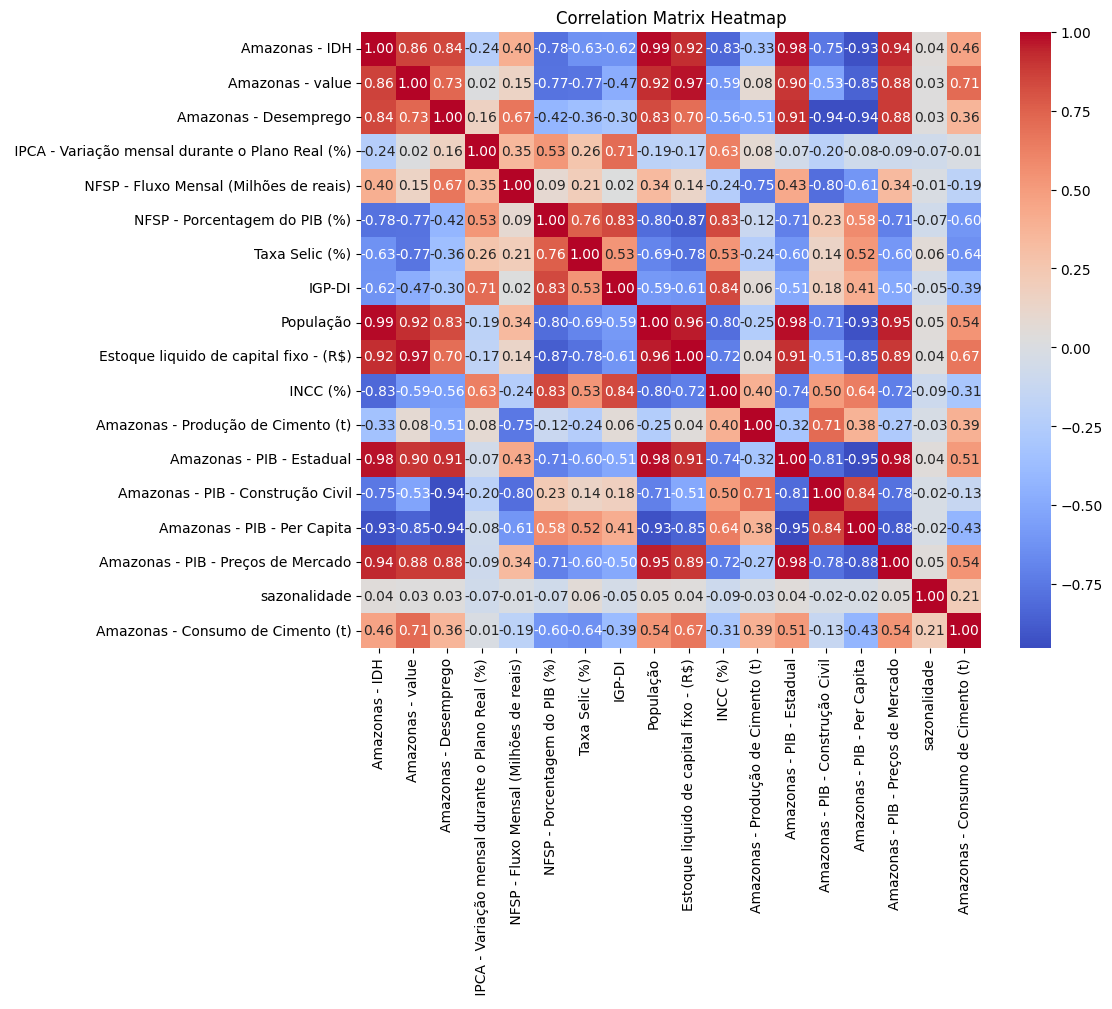

In [67]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [69]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amazonas - IDH,8.711258e+06
1,Amazonas - value,2.244913e+04
2,Amazonas - Desemprego,2.086412e+03
3,IPCA - Variação mensal durante o Plano Real (%),2.491295e+03
4,NFSP - Fluxo Mensal (Milhões de reais),2.364074e+02
5,NFSP - Porcentagem do PIB (%),3.865951e+02
6,Taxa Selic (%),5.618951e+01
7,IGP-DI,5.032920e+02
8,População,5.663957e+06
9,Estoque liquido de capital fixo - (R$),8.783528e+06


In [70]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 0


,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,sazonalidade
0,0.695898,0.330279,8.630942,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,51.313080,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,60.508000
1,0.696043,0.331137,8.624872,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,51.554195,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,54.841143
2,0.696187,0.331306,8.618803,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,51.523306,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,61.873571
3,0.696332,0.331791,8.612734,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,51.639628,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,59.048286
4,0.696476,0.332189,8.606665,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,51.838456,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,59.775929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.712440,0.536520,12.728440,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,36.487161,5.583488e+07,2.437451e+06,12.371872,4.428295e+07,65.537071
176,0.712329,0.538010,12.715207,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,35.825483,5.583822e+07,2.438197e+06,12.373814,4.428794e+07,64.252429
177,0.712217,0.539679,12.701973,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,35.241638,5.584156e+07,2.438943e+06,12.375756,4.429293e+07,68.678714
178,0.712105,0.540248,12.688740,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,34.630908,5.584490e+07,2.439689e+06,12.377697,4.429792e+07,65.397571


In [71]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado
0,0.000000,0.052061,1.000000,0.543630,1.000000,0.741706,1.000000,0.000000,0.000000,1.000000,0.572912,0.000000,0.613647,0.879074,0.000000
1,0.002941,0.050819,0.909144,0.544990,0.965719,0.573104,0.936603,0.008302,0.011007,0.968765,0.580847,0.006890,0.624331,0.887854,0.014632
2,0.003520,0.049577,0.853620,0.532585,0.927412,0.925680,0.906543,0.016605,0.022015,0.948151,0.579830,0.013780,0.635015,0.896634,0.029264
3,0.005180,0.048335,0.828878,0.504220,0.885588,0.542253,0.858675,0.024907,0.033022,0.928398,0.583658,0.020670,0.645699,0.905414,0.043896
4,0.006545,0.047093,0.796137,0.515509,0.838034,0.803992,0.824839,0.033209,0.044030,0.970256,0.590201,0.027560,0.656383,0.914194,0.058528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.706475,0.890502,0.038179,0.496222,0.033352,0.034086,0.168620,0.986456,0.889786,0.020697,0.085035,0.998392,0.036603,0.203302,0.982145
176,0.711579,0.887794,0.016717,0.473326,0.034217,0.187836,0.176428,0.989842,0.885419,0.019895,0.063261,0.998794,0.041832,0.214352,0.986609
177,0.717296,0.885086,0.004270,0.425824,0.035996,0.269786,0.174368,0.993228,0.881053,0.020180,0.044048,0.999196,0.047061,0.225403,0.991073
178,0.719245,0.882379,0.000000,0.448015,0.039184,0.360889,0.197726,0.996614,0.876686,0.007298,0.023951,0.999598,0.052290,0.236453,0.995536


In [72]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado
0,0.000000,0.052061,1.000000,0.543630,1.000000,0.741706,1.000000,0.000000,0.000000,1.000000,0.572912,0.000000,0.613647,0.879074,0.000000
1,0.002941,0.050819,0.909144,0.544990,0.965719,0.573104,0.936603,0.008302,0.011007,0.968765,0.580847,0.006890,0.624331,0.887854,0.014632
2,0.003520,0.049577,0.853620,0.532585,0.927412,0.925680,0.906543,0.016605,0.022015,0.948151,0.579830,0.013780,0.635015,0.896634,0.029264
3,0.005180,0.048335,0.828878,0.504220,0.885588,0.542253,0.858675,0.024907,0.033022,0.928398,0.583658,0.020670,0.645699,0.905414,0.043896
4,0.006545,0.047093,0.796137,0.515509,0.838034,0.803992,0.824839,0.033209,0.044030,0.970256,0.590201,0.027560,0.656383,0.914194,0.058528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.655976,0.947183,0.144755,0.772284,0.015040,0.428805,0.061396,0.945698,0.937006,0.094130,0.297725,0.985965,0.013001,0.080311,0.920653
164,0.658547,0.939638,0.133956,0.741958,0.016631,0.394850,0.095565,0.949109,0.933675,0.087555,0.282077,0.987888,0.010401,0.089438,0.926702
165,0.662344,0.932093,0.141095,0.686725,0.018850,0.402192,0.096417,0.952520,0.930344,0.083404,0.265736,0.989810,0.007801,0.098565,0.932751
166,0.667161,0.924547,0.102393,0.792808,0.020846,0.428809,0.052056,0.955931,0.927013,0.075773,0.251823,0.991732,0.005201,0.107693,0.938801


In [73]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
163    23.387
164    38.399
165    39.652
166    40.204
167    21.625
Name: Amazonas - Consumo de Cimento (t), Length: 168, dtype: float64

In [74]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [75]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 15)

In [76]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Amazonas - value,Amazonas - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amazonas - Produção de Cimento (t),Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado
132,0.985934,0.866311,0.710818,0.600233,0.076793,0.228507,0.297841,0.834889,1.000000,0.368307,0.675686,0.882319,0.282125,0.130712,0.843727
133,0.990046,0.875334,0.737933,0.683286,0.080065,0.227972,0.310249,0.838610,0.999030,0.356043,0.663234,0.886388,0.267239,0.119819,0.842696
134,0.993362,0.884357,0.731922,0.691333,0.083086,0.297136,0.298259,0.842332,0.998060,0.365871,0.652014,0.890458,0.252353,0.108926,0.841665
135,0.996564,0.893379,0.722500,0.683763,0.085709,0.190626,0.264133,0.846053,0.997090,0.374560,0.640731,0.894528,0.237467,0.098034,0.840634
136,1.000000,0.902402,0.735417,0.750790,0.089485,0.174875,0.283400,0.849774,0.996121,0.347016,0.629422,0.898597,0.222582,0.087141,0.839602
137,0.976706,0.911425,0.736663,0.748426,0.091963,0.212105,0.345980,0.853496,0.995151,0.340984,0.617770,0.902667,0.207696,0.076248,0.838571
138,0.965928,0.920448,0.750484,0.765274,0.093682,0.239148,0.355524,0.857217,0.994181,0.333970,0.606170,0.906736,0.192810,0.065356,0.837540
139,0.954750,0.929471,0.781650,0.799973,0.094876,0.292080,0.388252,0.860938,0.993211,0.316991,0.594420,0.910806,0.177924,0.054463,0.836509
140,0.943165,0.938494,0.780630,0.803815,0.095765,0.237576,0.392252,0.864660,0.992241,0.324046,0.582750,0.914876,0.163038,0.043571,0.835478
141,0.931217,0.947516,0.771685,0.692895,0.095412,0.297638,0.401389,0.868381,0.991271,0.324890,0.571085,0.918945,0.148152,0.032678,0.834447


In [77]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 15)

In [78]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [79]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [80]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [81]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[308292628, 4068684818, 3760553308, 3713005590, 5824164, 3075970688, 3719725821, 1703552442, 2582577950, 3271042625]


Step: 0 ___________________________________________
val_loss: 406.0594177246094
winner_seed: 308292628


Step: 1 ___________________________________________
val_loss: 401.6572265625
winner_seed: 4068684818


Step: 2 ___________________________________________
val_loss: 396.0320129394531
winner_seed: 3760553308


Step: 3 ___________________________________________
val_loss: 357.1528625488281
winner_seed: 3713005590


Step: 4 ___________________________________________
val_loss: 392.0412902832031


Step: 5 ___________________________________________
val_loss: 396.5628356933594


Step: 6 ___________________________________________
val_loss: 404.8163146972656


Step: 7 ___________________________________________
val_loss: 414.36944580078125


Step: 8 ___________________________________________
val_loss: 402.5008850097656


Step: 9 __________________________________________

In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 282560761

Epoch 1/10000
4/4 [==============================] - 2s 130ms/step - loss: 3787.9470 - val_loss: 1647.5001
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 235.7566 - val_loss: 1187.9896
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 213.4445 - val_loss: 1303.7684
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 223.9776 - val_loss: 1589.5165
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 261.8286 - val_loss: 749.4869
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 248.1154 - val_loss: 1252.2169
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 214.9226 - val_loss: 1431.7206
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 225.9968 - val_loss: 1063.3715
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 216.4797 - val_loss: 1152.3208
Epoch 10/10000
4/4 [==============================] - 

Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 160.7404 - val_loss: 448.2615
Epoch 80/10000
4/4 [==============================] - 0s 11ms/step - loss: 159.1941 - val_loss: 667.1590
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 208.0841 - val_loss: 580.8568
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 165.8861 - val_loss: 438.4696
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 155.4882 - val_loss: 425.1945
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 146.9882 - val_loss: 549.6886
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 178.1644 - val_loss: 595.6213
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 215.0939 - val_loss: 442.9332
Epoch 87/10000
4/4 [==============================] - 0s 12ms/step - loss: 150.3416 - val_loss: 536.6915
Epoch 88/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 9ms/step - loss: 106.3960 - val_loss: 596.2867
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.5251 - val_loss: 492.2385
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 112.1855 - val_loss: 416.5213
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.9720 - val_loss: 503.2759
Epoch 160/10000
4/4 [==============================] - 0s 8ms/step - loss: 101.5062 - val_loss: 451.7496
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.6024 - val_loss: 412.0324
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.4772 - val_loss: 459.7133
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 114.3724 - val_loss: 640.6633
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 121.4955 - val_loss: 419.6142
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 100.6596 - val_loss: 438.6312
Epoch 234/10000
4/4 [==============================] - 0s 11ms/step - loss: 104.1644 - val_loss: 477.5676
Epoch 235/10000
4/4 [==============================] - 0s 12ms/step - loss: 97.8134 - val_loss: 468.9490
Epoch 236/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.9837 - val_loss: 441.3590
Epoch 237/10000
4/4 [==============================] - 0s 11ms/step - loss: 173.9978 - val_loss: 471.2522
Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.3505 - val_loss: 468.1173
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.5089 - val_loss: 468.1186
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.1404 - val_loss: 562.0470
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 119.6081 - val_loss: 460.1956
Epoch 242/10000
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 10ms/step - loss: 98.6342 - val_loss: 451.7165
Epoch 311/10000
4/4 [==============================] - 0s 10ms/step - loss: 96.9027 - val_loss: 470.7640
Epoch 312/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.0113 - val_loss: 465.2488
Epoch 313/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.4452 - val_loss: 493.1655
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.3540 - val_loss: 416.9548
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.1392 - val_loss: 475.6845
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.1156 - val_loss: 520.6329
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 107.4238 - val_loss: 455.1901
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.8672 - val_loss: 428.4947
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step

Epoch 388/10000
4/4 [==============================] - 0s 10ms/step - loss: 99.5320 - val_loss: 465.5567
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 103.9919 - val_loss: 424.8481
Epoch 390/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.8496 - val_loss: 444.1711
Epoch 391/10000
4/4 [==============================] - 0s 13ms/step - loss: 98.3266 - val_loss: 446.5219
Epoch 392/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.1434 - val_loss: 443.1505
Epoch 393/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.2855 - val_loss: 419.0036
Epoch 394/10000
4/4 [==============================] - 0s 8ms/step - loss: 98.0873 - val_loss: 462.9536
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.6248 - val_loss: 513.8576
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.4208 - val_loss: 454.6126
Epoch 397/10000
4/4 [==============================] - 0s

Epoch 466/10000
4/4 [==============================] - 0s 11ms/step - loss: 114.7179 - val_loss: 434.9341
Epoch 467/10000
4/4 [==============================] - 0s 11ms/step - loss: 103.2388 - val_loss: 406.6125
Epoch 468/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.7578 - val_loss: 502.3878
Epoch 469/10000
4/4 [==============================] - 0s 11ms/step - loss: 104.4407 - val_loss: 484.9190
Epoch 470/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.9651 - val_loss: 421.2708
Epoch 471/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.5445 - val_loss: 452.0125
Epoch 472/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.9508 - val_loss: 503.4964
Epoch 473/10000
4/4 [==============================] - 0s 11ms/step - loss: 108.2547 - val_loss: 479.3317
Epoch 474/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.2665 - val_loss: 449.5352
Epoch 475/10000
4/4 [============================

Epoch 544/10000
4/4 [==============================] - 0s 11ms/step - loss: 104.8052 - val_loss: 478.8579
Epoch 545/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.9941 - val_loss: 480.9127
Epoch 546/10000
4/4 [==============================] - 0s 12ms/step - loss: 99.1266 - val_loss: 517.8062
Epoch 547/10000
4/4 [==============================] - 0s 12ms/step - loss: 104.6539 - val_loss: 456.6044
Epoch 548/10000
4/4 [==============================] - 0s 12ms/step - loss: 101.1459 - val_loss: 445.0572
Epoch 549/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.9577 - val_loss: 466.5127
Epoch 550/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.5194 - val_loss: 430.4591
Epoch 551/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.4057 - val_loss: 476.3368
Epoch 552/10000
4/4 [==============================] - 0s 10ms/step - loss: 96.3150 - val_loss: 496.9844
Epoch 553/10000
4/4 [=============================

Epoch 622/10000
4/4 [==============================] - 0s 10ms/step - loss: 102.1888 - val_loss: 469.2299
Epoch 623/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.0134 - val_loss: 454.9468
Epoch 624/10000
4/4 [==============================] - 0s 12ms/step - loss: 103.0481 - val_loss: 442.0966
Epoch 625/10000
4/4 [==============================] - 0s 12ms/step - loss: 95.1677 - val_loss: 463.1739
Epoch 626/10000
4/4 [==============================] - 0s 12ms/step - loss: 98.0269 - val_loss: 449.0613
Epoch 627/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.5221 - val_loss: 474.3059
Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.8758 - val_loss: 470.7413
Epoch 629/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.8475 - val_loss: 473.9712
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.1745 - val_loss: 459.4900
Epoch 631/10000
4/4 [==============================] 

Epoch 700/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.6923 - val_loss: 444.9296
Epoch 701/10000
4/4 [==============================] - 0s 10ms/step - loss: 96.5732 - val_loss: 436.1985
Epoch 702/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.8328 - val_loss: 462.0107
Epoch 703/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.9134 - val_loss: 464.1129
Epoch 704/10000
4/4 [==============================] - 0s 9ms/step - loss: 93.2371 - val_loss: 480.0267
Epoch 705/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.0589 - val_loss: 427.5547
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.9269 - val_loss: 453.4370
Epoch 707/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.4865 - val_loss: 453.3655
Epoch 708/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.7095 - val_loss: 439.0909
Epoch 709/10000
4/4 [==============================] - 

Epoch 778/10000
4/4 [==============================] - 0s 12ms/step - loss: 98.2161 - val_loss: 434.5202
Epoch 779/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.4050 - val_loss: 462.6756
Epoch 780/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.1351 - val_loss: 447.5397
Epoch 781/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.3341 - val_loss: 474.1358
Epoch 782/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.0988 - val_loss: 507.1440
Epoch 783/10000
4/4 [==============================] - 0s 11ms/step - loss: 103.4941 - val_loss: 453.1685
Epoch 784/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.7782 - val_loss: 491.8481
Epoch 785/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.3618 - val_loss: 483.3296
Epoch 786/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.1279 - val_loss: 474.0818
Epoch 787/10000
4/4 [==============================] 

Epoch 856/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.3401 - val_loss: 399.1895
Epoch 857/10000
4/4 [==============================] - 0s 11ms/step - loss: 105.5237 - val_loss: 449.1962
Epoch 858/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.6082 - val_loss: 464.8250
Epoch 859/10000
4/4 [==============================] - 0s 13ms/step - loss: 95.2234 - val_loss: 456.8356
Epoch 860/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.5844 - val_loss: 462.6492
Epoch 861/10000
4/4 [==============================] - 0s 12ms/step - loss: 105.9224 - val_loss: 428.2433
Epoch 862/10000
4/4 [==============================] - 0s 10ms/step - loss: 97.4314 - val_loss: 432.4379
Epoch 863/10000
4/4 [==============================] - 0s 10ms/step - loss: 96.0682 - val_loss: 463.8056
Epoch 864/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.0822 - val_loss: 460.4032
Epoch 865/10000
4/4 [==============================] 

Epoch 934/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.9759 - val_loss: 467.7002
Epoch 935/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.5682 - val_loss: 418.4251
Epoch 936/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.0059 - val_loss: 509.8547
Epoch 937/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.7559 - val_loss: 486.6710
Epoch 938/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.0216 - val_loss: 475.9384
Epoch 939/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.0521 - val_loss: 487.0971
Epoch 940/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.0278 - val_loss: 454.8127
Epoch 941/10000
4/4 [==============================] - 0s 12ms/step - loss: 91.5825 - val_loss: 452.8759
Epoch 942/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.3831 - val_loss: 414.3015
Epoch 943/10000
4/4 [==============================]

Epoch 1012/10000
4/4 [==============================] - 0s 12ms/step - loss: 93.0263 - val_loss: 442.8562
Epoch 1013/10000
4/4 [==============================] - 0s 12ms/step - loss: 91.8980 - val_loss: 458.0981
Epoch 1014/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.1066 - val_loss: 463.3285
Epoch 1015/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.5192 - val_loss: 439.4621
Epoch 1016/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.6150 - val_loss: 413.3134
Epoch 1017/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.0524 - val_loss: 449.0323
Epoch 1018/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.6926 - val_loss: 475.1928
Epoch 1019/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.2164 - val_loss: 444.4790
Epoch 1020/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.2311 - val_loss: 474.9974
Epoch 1021/10000
4/4 [========================

4/4 [==============================] - 0s 12ms/step - loss: 94.1071 - val_loss: 435.0147
Epoch 1090/10000
4/4 [==============================] - 0s 11ms/step - loss: 87.0957 - val_loss: 437.3640
Epoch 1091/10000
4/4 [==============================] - 0s 10ms/step - loss: 89.3304 - val_loss: 455.2526
Epoch 1092/10000
4/4 [==============================] - 0s 12ms/step - loss: 85.9231 - val_loss: 435.6668
Epoch 1093/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.8752 - val_loss: 448.0786
Epoch 1094/10000
4/4 [==============================] - 0s 10ms/step - loss: 90.3902 - val_loss: 428.9921
Epoch 1095/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.7670 - val_loss: 439.4609
Epoch 1096/10000
4/4 [==============================] - 0s 11ms/step - loss: 85.3046 - val_loss: 412.8163
Epoch 1097/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.6295 - val_loss: 445.8815
Epoch 1098/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 89.1516 - val_loss: 418.7486
Epoch 1167/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.1108 - val_loss: 424.7073
Epoch 1168/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.1956 - val_loss: 430.4471
Epoch 1169/10000
4/4 [==============================] - 0s 12ms/step - loss: 92.8606 - val_loss: 455.9048
Epoch 1170/10000
4/4 [==============================] - 0s 11ms/step - loss: 84.9146 - val_loss: 440.7875
Epoch 1171/10000
4/4 [==============================] - 0s 10ms/step - loss: 90.1693 - val_loss: 472.8134
Epoch 1172/10000
4/4 [==============================] - 0s 10ms/step - loss: 85.0320 - val_loss: 496.7141
Epoch 1173/10000
4/4 [==============================] - 0s 11ms/step - loss: 89.8041 - val_loss: 458.6031
Epoch 1174/10000
4/4 [==============================] - 0s 11ms/step - loss: 106.4727 - val_loss: 429.1765
Epoch 1175/10000
4/4 [==============================] - 0s 11m

4/4 [==============================] - 0s 9ms/step - loss: 129.8939 - val_loss: 477.1181
Epoch 1244/10000
4/4 [==============================] - 0s 9ms/step - loss: 94.3562 - val_loss: 449.9239
Epoch 1245/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.3750 - val_loss: 454.6661
Epoch 1246/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.6022 - val_loss: 460.1738
Epoch 1247/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.1831 - val_loss: 461.5462
Epoch 1248/10000
4/4 [==============================] - 0s 12ms/step - loss: 97.8874 - val_loss: 498.1415
Epoch 1249/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.5684 - val_loss: 445.4701
Epoch 1250/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.5213 - val_loss: 484.8544
Epoch 1251/10000
4/4 [==============================] - 0s 9ms/step - loss: 92.6964 - val_loss: 428.2419
Epoch 1252/10000
4/4 [==============================] - 0s 8ms/ste

4/4 [==============================] - 0s 11ms/step - loss: 170.7703 - val_loss: 609.7992
Epoch 1321/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3225 - val_loss: 569.2961
Epoch 1322/10000
4/4 [==============================] - 0s 11ms/step - loss: 160.4603 - val_loss: 530.4542
Epoch 1323/10000
4/4 [==============================] - 0s 11ms/step - loss: 160.5359 - val_loss: 1390.2346
Epoch 1324/10000
4/4 [==============================] - 0s 11ms/step - loss: 187.5748 - val_loss: 651.6294
Epoch 1325/10000
4/4 [==============================] - 0s 10ms/step - loss: 157.0551 - val_loss: 753.6271
Epoch 1326/10000
4/4 [==============================] - 0s 10ms/step - loss: 132.1747 - val_loss: 556.4622
Epoch 1327/10000
4/4 [==============================] - 0s 11ms/step - loss: 172.8520 - val_loss: 864.4008
Epoch 1328/10000
4/4 [==============================] - 0s 10ms/step - loss: 148.3818 - val_loss: 701.9988
Epoch 1329/10000
4/4 [==============================]

Epoch 1397/10000
4/4 [==============================] - 0s 11ms/step - loss: 115.5620 - val_loss: 577.3303
Epoch 1398/10000
4/4 [==============================] - 0s 11ms/step - loss: 138.2445 - val_loss: 433.0261
Epoch 1399/10000
4/4 [==============================] - 0s 10ms/step - loss: 109.2967 - val_loss: 454.9408
Epoch 1400/10000
4/4 [==============================] - 0s 10ms/step - loss: 108.6566 - val_loss: 514.6062
Epoch 1401/10000
4/4 [==============================] - 0s 10ms/step - loss: 114.6692 - val_loss: 447.8513
Epoch 1402/10000
4/4 [==============================] - 0s 11ms/step - loss: 116.6616 - val_loss: 551.5687
Epoch 1403/10000
4/4 [==============================] - 0s 11ms/step - loss: 109.1307 - val_loss: 501.2699
Epoch 1404/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.7271 - val_loss: 421.7000
Epoch 1405/10000
4/4 [==============================] - 0s 12ms/step - loss: 116.7582 - val_loss: 590.1252
Epoch 1406/10000
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 118.6330 - val_loss: 454.8873
Epoch 1474/10000
4/4 [==============================] - 0s 11ms/step - loss: 112.5600 - val_loss: 439.0096
Epoch 1475/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.8526 - val_loss: 484.1414
Epoch 1476/10000
4/4 [==============================] - 0s 10ms/step - loss: 119.6377 - val_loss: 515.7749
Epoch 1477/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.3451 - val_loss: 499.3977
Epoch 1478/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.6585 - val_loss: 403.8322
Epoch 1479/10000
4/4 [==============================] - 0s 10ms/step - loss: 108.9365 - val_loss: 473.5595
Epoch 1480/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.7671 - val_loss: 520.4070
Epoch 1481/10000
4/4 [==============================] - 0s 11ms/step - loss: 135.2058 - val_loss: 504.8031
Epoch 1482/10000
4/4 [==============================] -

Epoch 1550/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.8477 - val_loss: 465.4847
Epoch 1551/10000
4/4 [==============================] - 0s 10ms/step - loss: 102.3875 - val_loss: 508.8499
Epoch 1552/10000
4/4 [==============================] - 0s 9ms/step - loss: 110.4573 - val_loss: 459.4394
Epoch 1553/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.3503 - val_loss: 419.6474
Epoch 1554/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.2675 - val_loss: 459.2812
Epoch 1555/10000
4/4 [==============================] - 0s 9ms/step - loss: 112.8261 - val_loss: 429.9587
Epoch 1556/10000
4/4 [==============================] - 0s 8ms/step - loss: 100.4491 - val_loss: 487.4280
Epoch 1557/10000
4/4 [==============================] - 0s 9ms/step - loss: 101.8899 - val_loss: 521.8710
Epoch 1558/10000
4/4 [==============================] - 0s 10ms/step - loss: 105.6114 - val_loss: 424.5495
Epoch 1559/10000
4/4 [=======================

Epoch 1627/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.5162 - val_loss: 484.0414
Epoch 1628/10000
4/4 [==============================] - 0s 11ms/step - loss: 104.6653 - val_loss: 454.6471
Epoch 1629/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.0326 - val_loss: 527.7324
Epoch 1630/10000
4/4 [==============================] - 0s 10ms/step - loss: 109.1823 - val_loss: 514.4824
Epoch 1631/10000
4/4 [==============================] - 0s 10ms/step - loss: 108.0628 - val_loss: 455.1891
Epoch 1632/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.2694 - val_loss: 434.9120
Epoch 1633/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.4186 - val_loss: 471.6358
Epoch 1634/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.8905 - val_loss: 466.4752
Epoch 1635/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.4556 - val_loss: 484.4080
Epoch 1636/10000
4/4 [=================

4/4 [==============================] - 0s 11ms/step - loss: 98.3240 - val_loss: 454.7914
Epoch 1704/10000
4/4 [==============================] - 0s 12ms/step - loss: 103.4081 - val_loss: 519.8037
Epoch 1705/10000
4/4 [==============================] - 0s 11ms/step - loss: 106.4632 - val_loss: 503.1116
Epoch 1706/10000
4/4 [==============================] - 0s 12ms/step - loss: 105.6630 - val_loss: 469.6238
Epoch 1707/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.2438 - val_loss: 450.8082
Epoch 1708/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.4976 - val_loss: 439.2773
Epoch 1709/10000
4/4 [==============================] - 0s 10ms/step - loss: 99.5517 - val_loss: 464.8739
Epoch 1710/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.6226 - val_loss: 455.2435
Epoch 1711/10000
4/4 [==============================] - 0s 11ms/step - loss: 98.0488 - val_loss: 436.2092
Epoch 1712/10000
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 11ms/step - loss: 101.2651 - val_loss: 457.8608
Epoch 1781/10000
4/4 [==============================] - 0s 10ms/step - loss: 101.5261 - val_loss: 482.0237
Epoch 1782/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.9211 - val_loss: 467.5028
Epoch 1783/10000
4/4 [==============================] - 0s 11ms/step - loss: 103.1539 - val_loss: 462.7346
Epoch 1784/10000
4/4 [==============================] - 0s 10ms/step - loss: 104.1058 - val_loss: 445.7360
Epoch 1785/10000
4/4 [==============================] - 0s 10ms/step - loss: 100.4080 - val_loss: 460.9810
Epoch 1786/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.9057 - val_loss: 464.4078
Epoch 1787/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.1260 - val_loss: 486.8362
Epoch 1788/10000
4/4 [==============================] - 0s 10ms/step - loss: 99.9541 - val_loss: 481.4812
Epoch 1789/10000
4/4 [==============================] -

In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,44.506771,44.575142,44.588985,44.5966,44.612267,44.639572,44.586185,44.629814,44.672375,44.655651,44.625134,44.579376
Target,42.731,36.026,34.609,40.787,39.823,39.957,52.048,53.567,46.239,51.066,51.684,44.907
Error,1.775772,8.549141,9.979984,3.809601,4.789265,4.682571,7.461815,8.937187,1.566624,6.410351,7.058865,0.327625


In [85]:
display(mae)
display(mape)

5.4457335

0.12596434

In [86]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [87]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[535.2678]] - Target[533.444]| =  Error: [[1.8238525]]; MAPE:[[0.00341901]]


[array([[1.8238525]], dtype=float32)]

1.8238525

0.0034190142